# Transformers

Code heavily inspired and adapted from:
1. https://pytorch.org/tutorials/beginner/translation_transformer.html
2. https://towardsdatascience.com/how-to-code-the-transformer-in-pytorch-24db27c8f9ec#1b3f
3. https://github.com/harvardnlp/annotated-transformer/blob/master/The%20Annotated%20Transformer.ipynb
4. https://towardsdatascience.com/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
5. https://www.youtube.com/watch?v=U0s0f995w14&ab_channel=AladdinPersson
6. https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html
7. https://blog.floydhub.com/the-transformer-in-pytorch/
8. https://scale.com/blog/pytorch-improvements
9. https://colab.research.google.com/github/huggingface/blog/blob/master/notebooks/02_how_to_generate.ipynb#scrollTo=XbzZ_IVTtoQe


## Setting Up

In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-6b7f9a2b-6f3d-8c41-c2ad-76aec3660ba7)


In [1]:
from google.colab import drive
drive.mount('/content/gdrive') # for google colab. adjust accordingly

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
PARENT_DIR = '/content/gdrive/MyDrive/CS287_Research_Project/Jennas_Code/'

In [ ]:
#!pip install spacy
#!python -m spacy download en
#!python -m spacy download de

import pickle
from typing import List, Tuple, Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch import nn, optim
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch.distributions.beta import Beta

import math
import copy

import torchtext
from torchtext.data.metrics import bleu_score
from torchtext.legacy import data,datasets
#from torchtext import datasets
import sys
sys.path.append(PARENT_DIR)
#from load_data import load_pickled_dataloaders

from tqdm.notebook import tqdm
from random import random

from timeit import default_timer as timer

from seq2seqTF import *
from batchTF import *
from trainTF import *

from load_data import load_pickled_dataloaders
train_ds, val_ds, test_ds, train_dl, val_dl, test_dl = load_pickled_dataloaders(small = True, batch1 = False)

UNK_IDX = 0 
PADDING_IDX = 1 
BOS_IDX = 2
EOS_IDX = 3 

# def pad_collate(batch: List[Tuple[torch.tensor, torch.tensor]]) -> Tuple[torch.tensor, List, torch.tensor]:
#     sources = pad_sequence([tup[0] for tup in batch], 
#                            batch_first = True, padding_value = PADDING_IDX)
#     targets = pad_sequence([tup[1] for tup in batch], 
#                            batch_first = True, padding_value = PADDING_IDX)
#     return (sources, targets)

# train_dl = DataLoader(train_ds, collate_fn = pad_collate, num_workers=0, shuffle=True, batch_size=50)
# val_dl = DataLoader(val_ds, collate_fn = pad_collate, num_workers=0, shuffle=True, batch_size=50)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
val_ds.source_vocab_size

6561

## Data Info

In [ ]:
print(len(train_ds), len(val_ds), len(test_ds))

20611 89 157


In [ ]:
print(train_ds.source_vocab_size, train_ds.target_vocab_size)

6561 6059


## Data Loading

In [ ]:
train_ds, val_ds, test_ds, train_dl, val_dl, test_dl = load_pickled_dataloaders(small = True)

In [ ]:
len(train_ds)

119166

In [ ]:
next(iter(train_dl))

[tensor([[   2,   11, 1130,   19,  179,  165,   22,    9, 1353,  328,    4, 1404,
            90, 1414,    5,  733,   17,  176, 4467,  348,    5,   20, 2829, 2090,
             3]]),
 tensor([[   2,   14,  341,    8,  215,   31,   56,    4,  384,  452,    5,   14,
           137,   52, 1876,  288,    4, 1015,    7,   18,  123, 1535,  343, 4810,
            59,    4, 2476,    3]]),
 tensor([[ 0,  1,  2,  7,  8,  5,  4,  7,  8,  2, 10,  2,  7,  8,  7,  8,  4,  7,
           8,  2,  7,  7,  8,  2,  0]]),
 tensor([[ 0,  1,  2,  7,  8,  4,  5,  7,  8,  2, 10,  1,  2,  1,  8,  2,  7,  8,
           4,  5,  9,  9,  8,  2,  4,  7,  8,  0]])]

In [ ]:
# Some useful helper functions, which we will need for later...
UNK_IDX = 0 
PADDING_IDX = 1 
BOS_IDX = 2
EOS_IDX = 3 

def get_word_counts(reviews: List[List[str]]) -> Dict[str, int]:
    """
    Given a tokenized corpus (in this case reviews), we count the frequency of
    each word in the corpus
    """
    word_counts = {}
    for review in reviews:
        for word in review:
            if word in word_counts:
                word_counts[word] += 1
            else:
                word_counts[word] = 1
    return word_counts

def generate_vocab(word_counts: Dict[str, int], min_freq: int) -> Tuple[Dict[str, int], int]:
    """
    Given a set of word counts, we generate a vocabulary. We return two things
    from this method:

        1. A dict mapping tokens to indices
        2. THe length of the vocab
    
    Words that occur fewer than `min_freq` are replaced with <UNK>
    """

    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    vocab = {word: i+4 for i, (word, count) in enumerate(sorted_words) if count > min_freq}
    vocab["<PAD>"] = PADDING_IDX
    vocab["<EOS>"] = EOS_IDX 
    vocab["<UNK>"] = UNK_IDX
    vocab["<BOS>"] = BOS_IDX 
    return vocab, len(vocab)


In [ ]:
class TranslationDataset(Dataset):   
    def __init__(self, source: List[List[str]], target: List[List[str]], min_freq=3, source_vocab=None, target_vocab=None):
        super().__init__()
        
        if source_vocab is None and target_vocab is None:
            self.source_vocab, self.source_vocab_size = generate_vocab(get_word_counts(source), min_freq)
            self.target_vocab, self.target_vocab_size = generate_vocab(get_word_counts(target), min_freq)
        else:
            self.source_vocab = source_vocab
            self.source_vocab_size = len(source_vocab)

            self.target_vocab = target_vocab
            self.target_vocab_size = len(target_vocab)

        self.source, self.target = self._get_idx_dataset(source, target, self.source_vocab, self.target_vocab)
        
    def __len__(self):
        return len(self.target)
    
    def __getitem__(self, idx):
        return torch.tensor(self.source[idx]), torch.tensor(self.target[idx])

    def _get_idx_dataset(self, source: List[List[str]], target: List[List[str]], source_vocab: Dict[str, int], target_vocab: Dict[str, int]):
        source_toks = []
        target_toks = []

        for src, tar in zip(source, target):
            source_toks.append([source_vocab["<BOS>"]] + [source_vocab[token] if token in source_vocab else source_vocab["<UNK>"] for token in src] + [source_vocab["<EOS>"]])
            target_toks.append([target_vocab["<BOS>"]] + [target_vocab[token] if token in target_vocab else target_vocab["<UNK>"] for token in tar] + [target_vocab["<EOS>"]])
        
        return source_toks, target_toks



In [ ]:
with open(PARENT_DIR+"data/iwlst_train_sentences_small.pkl", "rb") as f: # Can edit based on need
    train_dict = pickle.load(f)
with open(PARENT_DIR+"data/iwlst_valid_sentences_small.pkl", "rb") as f:
    val_dict = pickle.load(f)
with open(PARENT_DIR+"data/iwlst_test_sentences_small.pkl", "rb") as f:
    test_dict = pickle.load(f)

# remove rows whose length > 32

def condition(x): return len(x)<=32
def dict_filter(d):
  # take in a dict, return a new one in which each element is less than 32
  # get idx in 'de'
  output = [idx for idx, element in enumerate(d['de']) if condition(element)]
  # subset 'de'
  d['de'] = [d['de'][i] for i in output]
  # subset 'en'
  d['en'] = [d['en'][i] for i in output]

  return d

# filter out the extra long rows in dictionaries
train_dict = dict_filter(train_dict)
val_dict = dict_filter(val_dict)
test_dict = dict_filter(test_dict)

train_ds = TranslationDataset(train_dict["de"], train_dict["en"])
test_ds = TranslationDataset(test_dict["de"], test_dict["en"], source_vocab=train_ds.source_vocab, target_vocab=train_ds.target_vocab)
val_ds = TranslationDataset(val_dict["de"], val_dict["en"], source_vocab=train_ds.source_vocab, target_vocab=train_ds.target_vocab)

In [ ]:
len(train_ds)

18927

In [ ]:
def pad_collate(batch: List[Tuple[torch.tensor, torch.tensor]]) -> Tuple[torch.tensor, List, torch.tensor]:
    sources = pad_sequence([tup[0] for tup in batch], 
                           batch_first = True, padding_value = PADDING_IDX)
    targets = pad_sequence([tup[1] for tup in batch], 
                           batch_first = True, padding_value = PADDING_IDX)
    return (sources, targets)
    
train_dl = DataLoader(train_ds, collate_fn=pad_collate, 
                         num_workers=0, shuffle=True, batch_size=50)
test_dl = DataLoader(test_ds, collate_fn=pad_collate, 
                        num_workers=0, shuffle=True, batch_size=50)
val_dl = DataLoader(val_ds, collate_fn=pad_collate, 
                       num_workers=0, shuffle=True, batch_size=50)

In [ ]:
next(iter(val_dl))

(tensor([[   2,   40,  154,  ...,    1,    1,    1],
         [   2,    6,    0,  ...,    3,    1,    1],
         [   2,   43,   10,  ...,    1,    1,    1],
         ...,
         [   2,   40,    0,  ...,    1,    1,    1],
         [   2,    5,  104,  ...,    1,    1,    1],
         [   2,    0, 2536,  ...,    1,    1,    1]]),
 tensor([[   2,   18,  134,  ...,    1,    1,    1],
         [   2,   19,    0,  ...,    1,    1,    1],
         [   2,   61,   16,  ...,    1,    1,    1],
         ...,
         [   2,   88, 4759,  ...,    1,    1,    1],
         [   2,    5,   42,  ...,    1,    1,    1],
         [   2,    0, 1975,  ...,    1,    1,    1]]))

## Model Components

### Sublayers

#### Layer Norm

In [ ]:
class LayerNorm(nn.Module):
  def __init__(self, d_model, eps = 1e-6):
    super().__init__()

    self.size = d_model

    self.alpha = nn.Parameter(torch.ones(self.size))
    self.bias = nn.Parameter(torch.zeros(self.size))
    
    self.eps = eps
  
  def forward(self, x):
    mean = x.mean(-1, keepdim=True)
    std = x.std(-1, keepdim=True)
    return self.alpha * (x - mean) / (std + self.eps) + self.bias

#### Sublayer Connection (Layer Norm + Residual Connection)

In [ ]:
class SublayerConnection(nn.Module):
  def __init__(self, size, dropout):
    super(SublayerConnection, self).__init__()
    self.norm = LayerNorm(size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, sublayer):
    # residual connection
    return x + self.dropout(sublayer(self.norm(x)))

#### FF

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, d_model, d_ff=2048, dropout = 0.1):
    super().__init__() 

    # Set d_ff as a default to 2048 bc Vaswani paper
    self.linear_1 = nn.Linear(d_model, d_ff)
    self.dropout = nn.Dropout(dropout)
    self.linear_2 = nn.Linear(d_ff, d_model)
  
  def forward(self, x):
    x = self.dropout(F.relu(self.linear_1(x)))
    x = self.linear_2(x)
    return x

#### Attention

In [ ]:
def attention(query, key, value, mask=None, dropout=None):
  #Scaled dot product attention
  d_k = query.size(-1)
  scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
  if mask is not None:
      scores = scores.masked_fill(mask == 0, -1e9)
  p_attn = F.softmax(scores, dim = -1)
  if dropout is not None:
      p_attn = dropout(p_attn)
  return torch.matmul(p_attn, value), p_attn

#### Multi-headed Attention

In [ ]:
class MultiHeadedAttention(nn.Module):
  def __init__(self, h, d_model, dropout=0.1):
    super(MultiHeadedAttention, self).__init__()
    self.d_k = math.floor(d_model/h) # = d_v
    self.h = h
    self.linears = clones(nn.Linear(d_model, d_model), 4)
    self.attn = None
    self.dropout = nn.Dropout(p=dropout)
      
  def forward(self, query, key, value, mask=None):
    if mask is not None:
      mask = mask.unsqueeze(1)
    nbatches = query.size(0)
      
    query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
      for l, x in zip(self.linears, (query, key, value))]

    x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)

    x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
    return self.linears[-1](x)

### Embedding

#### Embedding

In [ ]:
class Embedder(nn.Module):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embed = nn.Embedding(vocab_size, d_model)
  def forward(self, x):
    out = self.embed(x)
    return out

#### Positional Encoding

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, dropout=0.1, max_len=5000):
    super(PositionalEncoding, self).__init__()
    self.d_model = d_model
    self.dropout = nn.Dropout(p=dropout)
  
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) *
                          -(math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0)
    self.register_buffer('pe', pe)
      
  def forward(self, x):
    x *= math.sqrt(self.d_model) # Could move this to embeddings too 
    x = x + self.pe[:, :x.size(1)]
    return self.dropout(x)

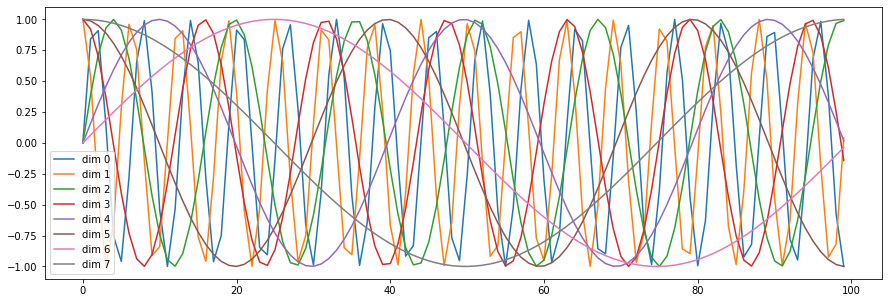

In [ ]:
# plt.figure(figsize=(15, 5))
# pe = PositionalEncoding(20, 0)
# y = pe.forward(torch.zeros(1, 100, 20))
# plt.plot(np.arange(100), y[0, :, 0:8].data.numpy())
# plt.legend(["dim %d"%p for p in list(range(9))])

### Layers

#### Clone (for stacks)

In [ ]:
def clones(module, N):
    # For encoder/decoder stacks
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

#### Encoder Layer

In [ ]:
class EncoderLayer(nn.Module):
  def __init__(self, size, self_attn, feed_forward, dropout=0.1):
      super(EncoderLayer, self).__init__()
      self.self_attn = self_attn
      self.feed_forward = feed_forward
      self.sublayer = clones(SublayerConnection(size, dropout), 2)
      self.size = size

  def forward(self, x, mask):
    x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
    return self.sublayer[1](x, self.feed_forward)

#### Decoder Layer

In [ ]:
class DecoderLayer(nn.Module):
  def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
    super(DecoderLayer, self).__init__()
    self.size = size
    self.self_attn = self_attn
    self.src_attn = src_attn
    self.feed_forward = feed_forward
    self.sublayer = clones(SublayerConnection(size, dropout), 3)

  def forward(self, x, memory, src_mask, tgt_mask):
    # Uses masking
    m = memory
    x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
    x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
    return self.sublayer[2](x, self.feed_forward)

### Stacks

#### Encoder Stack

In [ ]:
class Encoder(nn.Module):
  # Stack
  def __init__(self, layer, N):
    super(Encoder, self).__init__()
    self.layers = clones(layer, N)
    self.norm = LayerNorm(layer.size)
      
  def forward(self, x, mask):
    # Iterate through all layers in stack
    for layer in self.layers:
        x = layer(x, mask)
    return self.norm(x)

#### Decoder Stack

In [ ]:
class Decoder(nn.Module):  
  def __init__(self, layer, N):
    super(Decoder, self).__init__()
    self.layers = clones(layer, N)
    self.norm = LayerNorm(layer.size)
        
  def forward(self, x, memory, src_mask, tgt_mask):
    for layer in self.layers:
      x = layer(x, memory, src_mask, tgt_mask)
    return self.norm(x)

### Full Encoder ***Add Final Augs***

In [ ]:
class FullEncoder(nn.Module):
  def __init__(
        self, 

        # regular encoder parameters
        vocab_size: int,
        d_model: int,
        self_attn,
        feed_forward,
        dropout,
        N,
        padding_idx = PADDING_IDX, 
        device = "cuda",

        # augmentation encoder parameters    
        augmentation_type: str = None,  # one of "swap", "drop", "blank", "smooth", "lmsample"
        gamma = None, 
        k = None,                       # window size for "swap" method
        unk_idx = UNK_IDX,                 # placeholder for "blank" method
        unigram_freq = None,            # to sample from with "smooth" method
        language_model = None           # to sample from in "lmsample" method
    ):
    super(FullEncoder, self).__init__()
    self.input_size = vocab_size
    self.hidden_size = d_model
    self.padding_idx = padding_idx
    self.device = 'cuda'
    self.augmentation_type = augmentation_type
    self.gamma = gamma
    self.k = k
    self.unk_idx = unk_idx
    self.unigram_freq = unigram_freq
    self.language_model = language_model

    # Embedder
    self.embedding = Embedder(vocab_size, d_model)

    # Positional Encoder
    self.positional_encoder = PositionalEncoding(d_model)

    # Encoder Layers
    encoder_layer = EncoderLayer(d_model, self_attn, feed_forward, dropout)

    # Encoder
    self.encoder = Encoder(encoder_layer,N)

  def forward(self,
              # regular foward args
              input_seqs,
              src_mask,
              # augmentation forward args
              generate = False,
              lambda_ = None,
              mix_seqs = None, 
              input_pos = None, 
              mix_pos = None): 
      
    # Get embeddings
    embedded_input_seqs = self.embedding(input_seqs)

    # Augmentation
    # ************
    # ***INSERT***
    # ************

    # Positional encoding
    embedded_input_seqs = self.positional_encoder(embedded_input_seqs)

    # Encoding
    encoded_input_seqs = self.encoder(embedded_input_seqs, src_mask)
    return(encoded_input_seqs)

In [ ]:
src_vocab_size = train_ds.source_vocab_size
tgt_vocab_size = train_ds.target_vocab_size
N=6
d_model=512
d_ff=2048
h=8
dropout=0.1
device="cuda"
c = copy.deepcopy
self_attn = MultiHeadedAttention(h, d_model)
ff = FeedForward(d_model, d_ff, dropout)

testFullEncoder = FullEncoder(vocab_size = src_vocab_size,
                              d_model = d_model,
                              self_attn = c(self_attn),
                              feed_forward = c(ff),
                              dropout = dropout,
                              N = N,
                              gamma = None).to(device)

src, tgt = next(iter(train_dl))
src = src.to(device)
tgt = tgt.to(device)
batch = Batch(src,tgt,pad=PADDING_IDX)
memory = testFullEncoder(batch.src, batch.src_mask)

In [ ]:
memory.shape

torch.Size([50, 34, 512])

### Full Decoder

In [ ]:
class FullDecoder(nn.Module):
  def __init__(
        self, 

        # regular encoder parameters
        vocab_size: int,
        d_model: int,
        self_attn,
        feed_forward,
        dropout,
        N,
        padding_idx = PADDING_IDX, 
        device = "cuda",

        # augmentation encoder parameters    
        augmentation_type: str = None,  # one of "swap", "drop", "blank", "smooth", "lmsample"
        lambda_ = None                 # seqmix lambda parameter
    ):
    super(FullDecoder, self).__init__()
    self.input_size = vocab_size
    self.hidden_size = d_model
    self.padding_idx = padding_idx
    self.device = device
    self.augmentation_type = augmentation_type
    self.lambda_ = lambda_

    # Embedder
    self.embedding = Embedder(vocab_size, d_model)

    # Positional Encoder
    self.positional_encoder = PositionalEncoding(d_model)

    # Decoder Layers
    decoder_layer = DecoderLayer(d_model, self_attn, self_attn, feed_forward, dropout)

    # Encoder
    self.decoder = Decoder(decoder_layer,N)

  def forward(self,
              # regular foward args
              input_seqs, #tgt
              memory,
              src_mask,
              tgt_mask,
              # augmentation forward args
              mix_seqs = None,
              lambda_ = None,
              generate = False, 
              input_pos = None, 
              mix_pos = None): 
      
    # Get embeddings
    embedded_input_seqs = self.embedding(input_seqs)

    # Augmentation
    # ************
    # ***INSERT***
    # ************

    # Positional encoding
    embedded_input_seqs = self.positional_encoder(embedded_input_seqs)

    # Encoding
    decoded_input_seqs = self.decoder(embedded_input_seqs, memory, src_mask, tgt_mask)

    return(decoded_input_seqs)

In [ ]:
src_vocab_size = train_ds.source_vocab_size
tgt_vocab_size = train_ds.target_vocab_size
N=6
d_model=512
d_ff=2048
h=8
dropout=0.1
device="cuda"
c = copy.deepcopy

from layersTF import clones
from sublayersTF import MultiHeadedAttention, FeedForward


self_attn = MultiHeadedAttention(h, d_model)
ff = FeedForward(d_model, d_ff, dropout)

testFullDecoder = FullDecoder(vocab_size = tgt_vocab_size,
                              d_model = d_model,
                              self_attn = self_attn,
                              feed_forward = ff,
                              dropout = dropout,
                              N = N).to(device)

src, tgt = next(iter(train_dl))
src = src.to(device)
tgt = tgt.to(device)
batch = Batch(src,tgt,pad=PADDING_IDX)
out = testFullDecoder(batch.trg, memory, batch.src_mask, batch.trg_mask)

NameError: ignored

In [ ]:
batch.src.shape

torch.Size([50, 34])

### Masking

#### Decoder Masking

In [ ]:
def future_mask(size):
  # Upper triangular masking future words
  attn_shape = (1, size, size)
  future_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
  return torch.from_numpy(future_mask) == 0

#### All Masking

In [ ]:
class Batch:
    def __init__(self, src, trg=None, pad=0):
      self.src = src
      self.src_mask = (src != pad).unsqueeze(-2)
      if trg is not None:
        self.trg = trg[:, :-1]
        self.trg_y = trg[:, 1:]
        self.trg_mask = self.make_full_mask(self.trg, pad)
        self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_full_mask(tgt, pad):
      tgt_mask = (tgt != pad).unsqueeze(-2)
      tgt_mask = tgt_mask & future_mask(tgt.size(-1)).type_as(tgt_mask.data)
      return tgt_mask

### Model Architecture

In [ ]:
class EncoderDecoder(nn.Module):
  def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
    super(EncoderDecoder, self).__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.tgt_embed = tgt_embed
    self.generator = generator

    # maybe make it raw input here and put embedder in encoder
        
  def forward(self, src, tgt, src_mask, tgt_mask):
    return self.decode(self.encode(src, src_mask), src_mask,
                        tgt, tgt_mask)
  
  def encode(self, src, src_mask):
    # so pass in src nor src_embed(src) into encoder or some shit
    print(src.shape)
    return self.encoder(self.src_embed(src), src_mask)
  
  def decode(self, memory, src_mask, tgt, tgt_mask):
    print(memory.shape, src_mask.shape)
    return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

class Generator(nn.Module):
  def __init__(self, d_model, vocab_size):
    super(Generator, self).__init__()
    self.proj = nn.Linear(d_model, vocab_size)

  def forward(self, x):
    return F.log_softmax(self.proj(x), dim=-1)

### Updated Model Architecture

In [ ]:
class Seq2SeqTF(nn.Module):
  def __init__(self,
               src_vocab_size, 
               tgt_vocab_size,
               device,
               padding_idx,
               N=6, 
               d_model=512, 
               d_ff=2048, 
               h=8, 
               dropout=0.1):
    super(Seq2SeqTF, self).__init__()


    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = FeedForward(d_model, d_ff, dropout)

    self.encoder = FullEncoder(vocab_size = src_vocab_size,
                              d_model = d_model,
                              self_attn = c(self_attn),
                              feed_forward = c(ff),
                              dropout = dropout,
                              N = N,
                              padding_idx = padding_idx)

    self.decoder = FullDecoder(vocab_size = tgt_vocab_size,
                              d_model = d_model,
                              self_attn = c(self_attn),
                              feed_forward = c(ff),
                              dropout = dropout,
                              N = N,
                              padding_idx = padding_idx)

    self.proj = nn.Linear(d_model, tgt_vocab_size)

    self.zero = torch.Tensor([0]).to(device)

  def forward(self, 
              input_seqs, #src
              output_seqs, #output_seqs
              src_mask, 
              tgt_mask, 
              generate=False):
    
    memory = self.encode(input_seqs, src_mask)
    output = self.decode(output_seqs, memory, src_mask, tgt_mask)
    return(output)

  def encode(self, src, src_mask, generate = False):
    return(self.encoder(src, src_mask,generate=generate))

  def decode(self, tgt, memory, src_mask, tgt_mask, generate = False):
    return(self.decoder(tgt,memory,src_mask,tgt_mask,generate=generate))
  
  def generator(self, x):
    return F.log_softmax(self.proj(x), dim=-1)

In [ ]:
device = 'cuda'
test_model = Seq2SeqTF(src_vocab_size = train_ds.source_vocab_size,
                       tgt_vocab_size = train_ds.target_vocab_size,
                       device = device,
                       padding_idx = PADDING_IDX,
                       N = 6,
                       d_model = 512,
                       d_ff = 2048,
                       h = 8,
                       dropout = 0.1).to(device)

src, tgt = next(iter(train_dl))
src = src.to(device)
tgt = tgt.to(device)
batch = Batch(src,tgt,pad=PADDING_IDX)

#memory = test_model.encode(batch.src, batch.src_mask)
decoded = test_model.decode(batch.trg, test_model.encode(batch.src, batch.src_mask), batch.src_mask, batch.trg_mask)
out = test_model.generator(decoded)

NameError: ignored

In [ ]:
bruh = test_model.forward(batch.src, batch.trg, batch.src_mask, batch.trg_mask)

In [ ]:
out.shape

torch.Size([50, 51, 5112])

In [ ]:
bruh2 = test_model.generator(bruh)
bruh2.shape

torch.Size([50, 45, 5112])

## Model

### Defining Model

In [ ]:
def make_model(src_vocab_size, tgt_vocab_size, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
  c = copy.deepcopy
  attn = MultiHeadedAttention(h, d_model)
  ff = FeedForward(d_model, d_ff, dropout)
  position = PositionalEncoding(d_model, dropout)
  model = EncoderDecoder(
    Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
    Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
    nn.Sequential(Embedder(src_vocab_size, d_model), c(position)),
    nn.Sequential(Embedder(tgt_vocab_size, d_model), c(position)),
    Generator(d_model, tgt_vocab_size))
  
  # Straight from Vaswani paper (supposedly critical) and that one debugging lecture
  for p in model.parameters():
    if p.dim() > 1:
      nn.init.xavier_uniform_(p)
  return model

**IN PROGRESS**

In [ ]:
def make_custom_model(src_vocab_size, tgt_vocab_size, N=6, 
                      d_model=512, d_ff=2048, h=8, dropout=0.1):
  c = copy.deepcopy
  attn = MultiHeadedAttention(h, d_model)
  ff = FeedForward(d_model, d_ff, dropout)
  position = PositionalEncoding(d_model, dropout)
  model = EncoderDecoder(
    Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
    Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
    nn.Sequential(CustomEmbedder(src_vocab_size, 
                                 d_model), 
                                 c(position), ), # will go inside encoder
    nn.Sequential(Embedder(tgt_vocab_size, d_model), c(position)), # will go inside decoder
    Generator(d_model, tgt_vocab_size))
  
  # Straight from Vaswani paper (supposedly critical) and that one debugging lecture
  for p in model.parameters():
    if p.dim() > 1:
      nn.init.xavier_uniform_(p)
  return model

### Initiating Model

In [ ]:
Transformer = make_model(src_vocab_size= train_ds.source_vocab_size,
                         tgt_vocab_size = train_ds.target_vocab_size).to(device)

In [ ]:
loss_fn = CrossEntropyLoss(ignore_index=PADDING_IDX)
optimizer = torch.optim.Adam(Transformer.parameters(), lr = 0.0001, weight_decay=1E-6)

## Training

### Training Loop

In [ ]:
def train_epoch(model, optimizer):
    model.train()
    losses = 0

    for src, tgt in tqdm(train_dl,leave=False):
        src = src.to(device)
        tgt = tgt.to(device)
        batch = Batch(src,tgt,pad=PADDING_IDX)
        out = Transformer.forward(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
        out = Transformer.generator(out)
        out_reshape = out.reshape(-1, out.shape[-1])
        trg_y_reshape = batch.trg_y.reshape(-1)
        loss = loss_fn(out_reshape, trg_y_reshape)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses += loss.item()

    return losses / len(train_dl)


def val_epoch(model):
    model.eval()
    losses = 0

    for src, tgt in tqdm(val_dl,leave=False):
        src = src.to(device)
        tgt = tgt.to(device)
        batch = Batch(src,tgt,pad=PADDING_IDX)
        out = Transformer.forward(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
        out = Transformer.generator(out)
        out_reshape = out.reshape(-1, out.shape[-1])
        trg_y_reshape = batch.trg_y.reshape(-1)
        loss = loss_fn(out_reshape, trg_y_reshape)
        losses += loss.item()

    return losses / len(val_dl)

### Training Model

#### No Augmentation

In [ ]:
torch.manual_seed(100)
epochs = 10

for epoch in range(epochs):
    start_time = timer()
    train_loss = train_epoch(Transformer, optimizer)
    end_time = timer()
    val_loss = val_epoch(Transformer)
    print((f"Epoch: {epoch+1}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
torch.save(Transformer,f'{PARENT_DIR}customTF_base')

  0%|          | 0/379 [00:00<?, ?it/s]

torch.Size([50, 33])
torch.Size([50, 33, 512]) torch.Size([50, 1, 33])
torch.Size([50, 29])
torch.Size([50, 29, 512]) torch.Size([50, 1, 29])
torch.Size([50, 31])
torch.Size([50, 31, 512]) torch.Size([50, 1, 31])
torch.Size([50, 33])
torch.Size([50, 33, 512]) torch.Size([50, 1, 33])
torch.Size([50, 30])
torch.Size([50, 30, 512]) torch.Size([50, 1, 30])
torch.Size([50, 32])
torch.Size([50, 32, 512]) torch.Size([50, 1, 32])
torch.Size([50, 34])
torch.Size([50, 34, 512]) torch.Size([50, 1, 34])
torch.Size([50, 34])
torch.Size([50, 34, 512]) torch.Size([50, 1, 34])
torch.Size([50, 34])
torch.Size([50, 34, 512]) torch.Size([50, 1, 34])
torch.Size([50, 30])
torch.Size([50, 30, 512]) torch.Size([50, 1, 30])
torch.Size([50, 33])
torch.Size([50, 33, 512]) torch.Size([50, 1, 33])
torch.Size([50, 34])
torch.Size([50, 34, 512]) torch.Size([50, 1, 34])
torch.Size([50, 32])
torch.Size([50, 32, 512]) torch.Size([50, 1, 32])
torch.Size([50, 32])
torch.Size([50, 32, 512]) torch.Size([50, 1, 32])
torch.

KeyboardInterrupt: ignored

## Loading Model

In [ ]:
base_model = torch.load(f'{PARENT_DIR}customTF_base')

## Translating

### Greedy Decoding WHY SLOW

Import parameters into base (non custom embedder model) when doing translation

In [ ]:
def greedy_decode(model, src, max_len, start_symbol, end_symbol):
  src = src.to(device)
  src_mask = torch.ones(1,1,len(src)).to(device)
  memory = model.encode(src, src_mask)
  ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data).long()
  for i in range(max_len-1):
    tgt_mask = future_mask(ys.size(1)).type_as(src.data).long()
    #print(src.dtype, src_mask.dtype, memory.dtype, tgt_mask.dtype)
    #print(src.shape, src_mask.shape, memory.shape, tgt_mask.shape, ys.shape)
    out = model.decode(ys, memory, src_mask, tgt_mask)
    prob = model.generator(out[:, -1])
    _, next_word = torch.max(prob, dim = 1)
    next_word = next_word.data[0]
    ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    if next_word == end_symbol:
      break
  return ys

In [ ]:
model.eval()
src = torch.LongTensor([[1,2,3,4,5,6,7,8,9,10]])
print(greedy_decode(model, src, max_len=10, start_symbol=BOS_IDX, end_symbol=EOS_IDX))

torch.int64 torch.float32 torch.float32 torch.int64
torch.Size([1, 10]) torch.Size([1, 1, 1]) torch.Size([1, 10, 512]) torch.Size([1, 1, 1]) torch.Size([1, 1])
torch.int64 torch.float32 torch.float32 torch.int64
torch.Size([1, 10]) torch.Size([1, 1, 1]) torch.Size([1, 10, 512]) torch.Size([1, 2, 2]) torch.Size([1, 2])
torch.int64 torch.float32 torch.float32 torch.int64
torch.Size([1, 10]) torch.Size([1, 1, 1]) torch.Size([1, 10, 512]) torch.Size([1, 3, 3]) torch.Size([1, 3])
torch.int64 torch.float32 torch.float32 torch.int64
torch.Size([1, 10]) torch.Size([1, 1, 1]) torch.Size([1, 10, 512]) torch.Size([1, 4, 4]) torch.Size([1, 4])
torch.int64 torch.float32 torch.float32 torch.int64
torch.Size([1, 10]) torch.Size([1, 1, 1]) torch.Size([1, 10, 512]) torch.Size([1, 5, 5]) torch.Size([1, 5])
torch.int64 torch.float32 torch.float32 torch.int64
torch.Size([1, 10]) torch.Size([1, 1, 1]) torch.Size([1, 10, 512]) torch.Size([1, 6, 6]) torch.Size([1, 6])
torch.int64 torch.float32 torch.float32 

### Translating Corpus

In [ ]:
MAX_STEPS = 40
def translate_corpus(
  vocab: Dict[str, int], 
  test_dl: DataLoader, 
  model: nn.Module,
  eos_idx,
  bos_idx) -> Tuple[List[List[str]], List[List[List[str]]]]:
  
  index_to_word = {v: k for k, v in vocab.items()}
  candidate_text = []
  reference_text = []

  for batch_idx, batch in enumerate(tqdm(test_dl,leave=False)):
    source = batch[0]
    target = batch[1]
    for i in range(len(source)):  # for seq in batch
      source = source.to(device)
      src_seq = source[i,:].unsqueeze(0)
      cand = greedy_decode(model, src_seq, MAX_STEPS, BOS_IDX, EOS_IDX)[0]
      cand = [index_to_word[int(cand[j])] for j in range(len(cand))]
      ref = [index_to_word[int(target[i][j])] for j in range(len(target[i])) if int(target[i][j]) != 0]
      candidate_text.append(cand)
      reference_text.append([ref])
      
  return candidate_text, reference_text

## Evaluation

In [ ]:
candidate_text, reference_text = translate_corpus(train_ds.target_vocab, test_dl, model, eos_idx = EOS_IDX, bos_idx = BOS_IDX)
bleu = bleu_score(candidate_text, reference_text, max_n=1, weights=[1])
bleu

  0%|          | 0/157 [00:00<?, ?it/s]

0.028496986255049706

In [ ]:
import embeddingTF

In [ ]:
import sublayersTF

In [ ]:
import layersTF

In [ ]:
import stacksTF

In [ ]:
import encoderTF

In [ ]:
import decoderTF

In [ ]:
import seq2seqTF

In [ ]:
from seq2seqTF import Seq2SeqTF

In [ ]:
UNK_IDX = 0 
PADDING_IDX = 1 
BOS_IDX = 2
EOS_IDX = 3 

device = 'cuda'
test_model = Seq2SeqTF(src_vocab_size = train_ds.source_vocab_size,
                       tgt_vocab_size = train_ds.target_vocab_size,
                       device = device,
                       padding_idx = PADDING_IDX,
                       N = 6,
                       d_model = 512,
                       d_ff = 2048,
                       h = 8,
                       dropout = 0.1).to(device)

src, tgt = next(iter(train_dl))
src = src.to(device)
tgt = tgt.to(device)
batch = Batch(src,tgt,pad=PADDING_IDX)

#memory = test_model.encode(batch.src, batch.src_mask)
decoded = test_model.decode(batch.trg, test_model.encode(batch.src, batch.src_mask), batch.src_mask, batch.trg_mask)
out = test_model.generator(decoded)

ValueError: ignored

In [ ]:
def train_epoch(model, optimizer, loss_fn, train_dl):
    model.train()
    losses = 0

    for batch_idx, batch in enumerate(tqdm(train_dl,leave=False)):
        src = batch[0].to(device)
        tgt = batch[1].to(device)
        batch = Batch(src,tgt,pad=padding_idx)
        out = model.forward(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
        out = model.generator(out)
        out_reshape = out.reshape(-1, out.shape[-1])
        trg_y_reshape = batch.trg_y.reshape(-1)
        loss = loss_fn(out_reshape, trg_y_reshape)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses += loss.item()

    return losses / len(train_dl)


def val_epoch(model, loss_fn, val_dl):
    model.eval()
    losses = 0

    for batch_idx, batch in enumerate(tqdm(val_dl,leave=False)):

        src = batch[0].to(device)
        tgt = batch[1].to(device)
        batch = Batch(src,tgt,pad=padding_idx)
        out = model.forward(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
        out = model.generator(out)
        out_reshape = out.reshape(-1, out.shape[-1])
        trg_y_reshape = batch.trg_y.reshape(-1)
        loss = loss_fn(out_reshape, trg_y_reshape)
        losses += loss.item()

    return losses / len(val_dl)

In [ ]:
UNK_IDX = 0 
PADDING_IDX = 1 
BOS_IDX = 2
EOS_IDX = 3 
device = 'cuda' #torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Seq2SeqTF(src_vocab_size = train_ds.source_vocab_size,
                       tgt_vocab_size = train_ds.target_vocab_size,
                       device = device,
                       padding_idx = PADDING_IDX,
                       N = 6,
                       d_model = 512,
                       d_ff = 2048,
                       h = 8,
                       dropout = 0.1).to(device)


1

In [ ]:
import random
import os


def train(model, 
          train_ds, 
          train_dl, 
          val_ds, 
          val_dl, 
          device, 
          bos_idx, 
          eos_idx, 
          padding_idx, 
          epochs, 
          lr, 
          weight_decay,
          max_steps,
          path,
          overwrite = True):
  torch.manual_seed(100)

  if not os.path.isdir(path):
      print('creating directory', path)
      os.mkdir(path)
  else:
    print('directory already exists')
    print(path, 'contains', os.listdir(path))
    if overwrite:
      print('continuing anyways... some files may be overwritten')
    else:
      print('set overwrite = True to continue')
      return None

  if not path.endswith('/'):
    path = path + '/'

  optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=weight_decay)
  loss_fn = CrossEntropyLoss(ignore_index=padding_idx)                      
  epochs = epochs

  train_losses = []
  val_losses = []
  bleus = []
  model_paths = []

  for epoch in range(epochs):
      start_time = timer()
      train_loss = train_epoch(model, optimizer, loss_fn, train_dl)
      train_losses.append(train_loss)
      end_time = timer()
      val_loss = val_epoch(model, loss_fn, val_dl)
      val_losses.append(val_loss)
      print((f"Epoch: {epoch+1}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f},"f"Epoch time = {(end_time - start_time):.3f}s"))

      candidate_text, reference_text = translate_corpus(train_ds.target_vocab, val_dl, model, eos_idx, bos_idx)
      bleu = bleu_score(candidate_text, reference_text, max_n=1, weights=[1])
      bleus.append(bleu)
      print((f"Validation Bleu: {bleu}"))

      model_path = path + 'epoch' + str(epoch)
      torch.save(model, model_path)
      model_paths.append(model_path)

  best_bleu = max(bleus)
  which = bleus.index(best_bleu)
  best_model_path = model_paths[which]
  best_model = torch.load(best_model_path)

  return(best_model, train_losses, val_losses, bleus, which)

In [ ]:
def pad_collate(batch: List[Tuple[torch.tensor, torch.tensor]]) -> Tuple[torch.tensor, List, torch.tensor]:
    sources = pad_sequence([tup[0] for tup in batch], 
                           batch_first = True, padding_value = PADDING_IDX)
    targets = pad_sequence([tup[1] for tup in batch], 
                           batch_first = True, padding_value = PADDING_IDX)
    return (sources, targets)

train_dl = DataLoader(train_ds, collate_fn = pad_collate, num_workers=0, shuffle=True, batch_size=50)
val_dl = DataLoader(val_ds, collate_fn = pad_collate, num_workers=0, shuffle=True, batch_size=50)

## Testing

In [ ]:
def get_unigram_freq(dl, vocab_length):
  freqs = [0]*vocab_length
  total = 0
  for batch in iter(dl):
    input_seqs = batch[0]
    for seq in input_seqs:
      for token in seq:
        total += 1
        freqs[int(token)] += 1
  freqs = np.array(freqs)
  freqs = freqs/sum(freqs)
  return freqs

In [ ]:
uni = get_unigram_freq(train_dl, len(train_ds.source_vocab))

In [4]:
UNK_IDX = 0 
PADDING_IDX = 1 
BOS_IDX = 2
EOS_IDX = 3 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Seq2SeqTF(src_vocab_size = train_ds.source_vocab_size,
                  tgt_vocab_size = train_ds.target_vocab_size,
                  device = device,
                  padding_idx = PADDING_IDX,
                  N = 6,
                  d_model = 512,
                  d_ff = 2048,
                  h = 8,
                  dropout = 0.1).to(device)
best_model, train_losses, val_losses, bleus, which = train(model,
                                        train_ds,
                                        train_dl,
                                        val_ds,
                                        val_dl,
                                        device = device,
                                        bos_idx = BOS_IDX,
                                        eos_idx = EOS_IDX,
                                        padding_idx = PADDING_IDX,
                                        epochs = 1,
                                        lr = 0.001,
                                        weight_decay = 1E-6,
                                        max_steps=40,
                                        path = "testing",
                                        overwrite = True)

directory already exists
testing contains []
continuing anyways ... some files may be overwritten


  0%|          | 0/645 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
print(model.encoder.unigram_freq)
  

None


In [ ]:
model = Seq2SeqTF(src_vocab_size = train_ds.source_vocab_size,
                  tgt_vocab_size = train_ds.target_vocab_size,
                  device = device,
                  padding_idx = PADDING_IDX,
                  N = 6,
                  d_model = 512,
                  d_ff = 2048,
                  h = 8,
                  dropout = 0.1,
                  augmentation_type = "smooth",
                  gamma = 0.10,
                  unigram_freq = uni).to(device)

In [ ]:
uni

array([3.08924465e-02, 6.73589973e-01, 1.80902979e-02, ...,
       3.51080450e-06, 3.51080450e-06, 3.51080450e-06])